This is a script to build a QSVT quantum circuit to perform quantum simulation of spin models. The algorithm is composed of two parts: 

1.   Generate the block-encoding of the given spin Hamiltonians;
2.   Build the correpsonding QSVT quantum circuit using given phase angles. 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,"/content/drive/My Drive/coherent-one-shot/Coherent_One_Shot")


Mounted at /content/drive


In [ ]:
!pip install qiskit ipywidgets; # Install qiskit for colab

     |████████████████████████████████| 6.1 MB 4.2 MB/s 
     |████████████████████████████████| 18.0 MB 127 kB/s 
     |████████████████████████████████| 235 kB 63.3 MB/s 
     |████████████████████████████████| 207 kB 62.5 MB/s 
     |████████████████████████████████| 2.1 MB 41.5 MB/s 
     |████████████████████████████████| 200 kB 53.6 MB/s 
     |████████████████████████████████| 1.4 MB 45.2 MB/s 
     |████████████████████████████████| 635 kB 37.4 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 38.2 MB 24 kB/s 
     |████████████████████████████████| 943 kB 42.9 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 3.0 MB 44.6 MB/s 
     |████████████████████████████████| 6.3 MB 58.9 MB/s 
  Created wheel for qiskit: filename=qiskit-0.29.1-py3-none-any.whl size=11239 sha256=d0396768e7bf6152b49f2d89936aecc73f55a03d1e2506eff39731fd33e9ef52
  Stored in directory: /root/.cache/pip/whe

In [ ]:

def printA(a):
    for row in a:
        for col in row:
            print("{:9.6f}".format(col), end=" ")
        print("")

def printrA(a):
    for row in a:
        for col in row:
            print("{:9.6f}".format(col.real), end=" ")
        print("")


In [ ]:
class bespin1d:
  ''' Class for generating the block-encoding of 1d Heisenberg model in random field '''
  'only works for n = 2 now. Need to make it work for any n.'

  def __init__(self, n, gx, gy, gz, fields, alpha, beta):
    self.n = n
    self.dim = pow(2,n)
    self.gx = gx
    self.gy = gy
    self.gz = gz
    self.fields = fields
    self.alpha = alpha
    self.beta = beta
    self.paulis = [[[ 0, 1], [1, 0]], [[ 0, -1j], [1j, 0]] , [[1,0],[0,-1]]]
    return

  def hsu4(self):
    # the 4x4 hamiltonian for 2 spin in the XYZ model
    hsu4 = np.zeros((4,4))
    hsu4[0,0] = self.gz
    hsu4[0,3] = self.gx - self.gy
    hsu4[1,1] = -self.gz
    hsu4[1,2] = self.gx + self.gy
    hsu4[2,1] = self.gx + self.gy
    hsu4[2,2] = -self.gz
    hsu4[3,0] = self.gx - self.gy
    hsu4[3,3] = self.gz
    return hsu4

  def h0(self):

    hsu4 = self.hsu4()

    h = np.zeros((self.dim, self.dim))
    # Loop over all site to build the XYZ Hamiltonian without fields
    for isite in range(self.n-1):
      if isite < self.n - 1:
        premat = np.eye(pow(2,isite))
        posmat = np.eye(pow(2,self.n - isite - 2))
        htemp = np.kron(premat, hsu4)
        htemp = np.kron(htemp, posmat)
      #else: open boundary condition; need to fix for periodic boundary condition later
        #premat = np.eye(pow(2, self.n - 2))
        #htemp = np.kron(premat, hsu4)

      h = h + htemp
    return h

  def hfull(self):

    # First generate hamiltonian without fields
    h = self.h0()

    # Add the random fields on each site now
    for isite in range(self.n):
      premat = np.eye(pow(2,isite))
      posmat = np.eye(pow(2,self.n - isite - 1))
      fsu2 = [[ self.fields[isite], 0], [0, -self.fields[isite] ]]
      ftemp = np.kron(premat, fsu2)
      ftemp = np.kron(ftemp, posmat)

      h = h + ftemp
    return h

  def be_h0(self):
    # construct a block encoding of h0
    h0 = self.h0() / self.alpha
    p0 = sqrtm(np.eye(pow(2, self.n)) - np.linalg.matrix_power(h0, 2))
    u0 = np.block([[h0, p0],[np.matrix(p0).getH(), -h0]])
    return u0

  def be_hfull(self):
    # construct block-encoding of hfull
    h = self.hfull() / self.alpha
    p = sqrtm(np.eye(pow(2, self.n)) - np.linalg.matrix_power(h, 2))
    u = np.block([[h, p],[np.matrix(p).getH(), -h]])
    return u

  def be_resh0(self):
    # construct block-encoding of the rescaled and shifted h0' = (I + beta/alpha * h0) / 2
    h0 = (np.eye(self.dim) + self.beta * self.h0() / self.alpha) / 2
    p0 = sqrtm(np.eye(pow(2, self.n)) - np.linalg.matrix_power(h0, 2))
    u0 = np.block([[h0, p0],[np.matrix(p0).getH(), -h0]])
    return u0

  def be_reshfull(self):
    # construct block-encoding of the rescaled and shifted hfull' = (I + beta/alpha * hfull) / 2
    h = (np.eye(self.dim) + self.beta * self.hfull() / self.alpha) / 2
    p = sqrtm(np.eye(pow(2, self.n)) - np.linalg.matrix_power(h, 2))
    u = np.block([[h, p],[np.matrix(p).getH(), -h]])
    return u

  def qsp_circ_h0(self, phases):
    # generate a quantum circuit for the block-encoding of h0
    qc = QuantumCircuit(self.n+1, name='U_0')
    qc.unitary(self.be_resh0(),np.arange(self.n+1).tolist())
    trans_qc = transpile(qc, basis_gates=['cx','u3'])
    circu = trans_qc.to_gate()

    nphase = phases.shape[0]
    qctot = QuantumCircuit(self.n+1, name='QSP_U')
    qctot.rz(phases[0], self.n)
    for ip in range (nphase-1):
      qctot.append(circu,np.arange(self.n+1).tolist())
      qctot.rz(phases[ip+1], self.n)
    
    print("QSP circuit:")
    print(qctot.draw())

    job = backend.run(transpile(qctot, backend))
    umat = job.result().get_unitary(qctot, decimals = 6)
    umat00 = umat[0:self.dim,0:self.dim]
    #umat11 = umat[16:31,16:31]
    #umat01 = umat[0:15,16:31]
    #umat10 = umat[16:31,0:15]
    #printA(umat00)
    printrA(umat00)
    printA(umat)
    return qctot


  def qsp_circ_hfull(self, phases, vecin):
    # generate a quantum circuit for the block-encoding of hfull
    qc = QuantumCircuit(self.n+1, name='U')
    qc.unitary(self.be_reshfull(),np.arange(self.n+1).tolist())
    trans_qc = transpile(qc, basis_gates=['cx','u3'])
    circu = trans_qc.to_gate()

    nphase = phases.shape[0]
    qctot = QuantumCircuit(self.n+1, name='QSP_U')
    qctot.rz(-2*phases[-1], self.n)
    for ip in reversed(range(nphase-1)):
      qctot.append(circu,np.arange(self.n+1).tolist())
      qctot.rz(-2*phases[ip], self.n)
    
    print("QSP circuit:")
    print(qctot.draw())

    job = backend.run(transpile(qctot, backend))
    umat = job.result().get_unitary(qctot, decimals = 6)
    umat00 = umat[0:self.dim,0:self.dim]/np.exp(-1j/self.beta)
    vecout = np.dot(umat00, vecin)
    #umat11 = umat[16:31,16:31]
    #umat01 = umat[0:15,16:31]
    #umat10 = umat[16:31,0:15]
    #printA(umat00)
    return vecout, umat00


  def dynamics_h0_ed(self, t, vecin):
    # simulate the exact time-evolution of h0
    val, vec = LA.eigh(self.h0())
    expval = np.exp(-1.0j*t*val)
    u_ed = np.zeros((self.dim, self.dim))
    u_ed = np.matmul( np.matmul(vec, np.diag(expval)), vec.conjugate().T)
    vecout = np.dot(u_ed, vecin)
    return vecout

  def dynamics_hfull_ed(self, t, vecin):
    # simulate the exact time-evolution of hfull
    val, vec = LA.eigh(self.hfull())
    expval = np.exp(-1.0j*t*val)
    u_ed = np.zeros((self.dim, self.dim))
    u_ed = np.matmul( np.matmul(vec, np.diag(expval)), vec.conjugate().T)
    vecout = np.dot(u_ed, vecin)
    return vecout, u_ed

  def measure_s(self, isite, vecin):
    # measure the expectation value of Pauli operators on site isite, from a given state vector 'vecin'
    premat = np.eye(pow(2,isite))
    posmat = np.eye(pow(2,self.n - isite - 1))
    
    s = np.zeros(3)

    for ip in range(3):
      op = np.kron(premat, self.paulis[ip])
      op = np.kron(op, posmat)
      s[ip] = np.dot(vecin.conjugate(), np.dot(op, vecin))
    return s

  def measure_ss(self, isite, jsite, vecin):
    # measure the expectation value of spin-spin correlation function, from a given state vector 'vecin'
    
    ss = np.zeros(3)

    for ip in range(3):
      op = np.kron(self.paulis[ip],self.paulis[ip])
      ss[ip] = np.dot(vecin.conjugate(), np.dot(op, vecin))
    return ss
    
    
  

In [ ]:
import numpy as np
from numpy import array, matrix
from numpy import linalg as LA
from scipy.io import mmread, mmwrite
from scipy.linalg import sqrtm, expm
import matplotlib.pyplot as plt
from math import pi
from qiskit.circuit import QuantumCircuit, ClassicalRegister, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit import transpile, BasicAer
from qiskit.quantum_info import Operator
from qiskit.tools.visualization import circuit_drawer

backend = BasicAer.get_backend('unitary_simulator')


In [ ]:
#Hamiltonian Properties

h1 = 0
h2 = 0
gx = 1
gy = 0
gz = 0

eigenvals = np.array([-gz-(gx**2+2*gx*gy+gy**2+h1**2-2*h1*h2+h2**2)**0.5, 
                      -gz+(gx**2+2*gx*gy+gy**2+h1**2-2*h1*h2+h2**2)**0.5,
                      gz-(gx**2+2*gx*gy+gy**2+h1**2-2*h1*h2+h2**2)**0.5,
                      gz+(gx**2+2*gx*gy+gy**2+h1**2-2*h1*h2+h2**2)**0.5])
alpha = max(np.abs(eigenvals))
beta = 1/2


nsite = 2;
eigenvals

array([-1.,  1., -1.,  1.])

In [ ]:
heisenberg2 = bespin1d(nsite, gx, gy, gz, [h1, h2], alpha, beta)
heisenberg2.hsu4()
heisenberg2.hfull()

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

In [ ]:
resh = np.array(heisenberg2.be_reshfull()[0:4,0:4])
w, v = LA.eigh(resh)
print(w)
expm(-2j*alpha/beta*resh)/np.exp(-1j/beta)

[0.25 0.25 0.75 0.75]


array([[ 5.40302306e-01+5.04761470e-17j, -0.00000000e+00-0.00000000e+00j,
        -0.00000000e+00-0.00000000e+00j,  5.04761470e-17-8.41470985e-01j],
       [-0.00000000e+00-0.00000000e+00j,  5.40302306e-01+5.04761470e-17j,
         5.04761470e-17-8.41470985e-01j, -0.00000000e+00-0.00000000e+00j],
       [-0.00000000e+00-0.00000000e+00j, -0.00000000e+00-8.41470985e-01j,
         5.40302306e-01+5.04761470e-17j, -0.00000000e+00-0.00000000e+00j],
       [-0.00000000e+00-8.41470985e-01j, -0.00000000e+00-0.00000000e+00j,
        -0.00000000e+00-0.00000000e+00j,  5.40302306e-01+5.04761470e-17j]])

In [ ]:
# Define the QSP phases for the one-shot simulation, read from external file

with open('/content/drive/My Drive/coherent-one-shot/Coherent_One_Shot/phase_t3.npy', 'rb') as f:
  phases = np.load(f)

# Processing the phases such that it is consistent with the convention
phases = phases.reshape(-1)
phases[0] = phases[0] + pi/4
phases[-1] = phases[-1] + pi/4
for i in range(1,(phases.size-1)):
  phases[i] = phases[i] + pi/2

In [ ]:
phases

array([1.7523495, 3.7252939, 3.6471236, 2.3650663, 1.9054856, 2.6817145,
       3.2014694, 2.2930508, 4.455276 , 4.452726 , 2.9718432, 3.252752 ,
       2.4753482, 3.1326745, 2.0334988, 4.4585195, 4.1785507, 4.663492 ,
       2.320948 , 2.7171512, 3.2440841, 1.9738762, 3.4542909, 1.8450624,
       2.4062567, 2.0244687, 4.4431114, 3.9777958, 3.468035 , 1.9272189,
       1.7090225], dtype=float32)

In [ ]:
# Perform the exact time evolution

npts = 41
t = [i*0.1 for i in range(npts)]
s_result = np.zeros((npts,3))
vout = np.zeros(heisenberg2.dim)
ued = np.zeros(heisenberg2.dim)
for i in range(npts):
  vout, ued = heisenberg2.dynamics_hfull_ed(t[i], [1,0,0,0])
  s_result[i] = heisenberg2.measure_s(0, vout)
printA(ued)

-0.653644+0.000000j 0.000000+0.000000j 0.000000+0.000000j 0.000000+0.756802j 
0.000000+0.000000j -0.653644+0.000000j 0.000000+0.756802j 0.000000+0.000000j 
0.000000+0.000000j 0.000000+0.756802j -0.653644+0.000000j 0.000000+0.000000j 
0.000000+0.756802j 0.000000+0.000000j 0.000000+0.000000j -0.653644+0.000000j 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
# Perform the QSP approximate time evolution

s_result_qsp = np.zeros((1,3))
vout_qsp = np.zeros(heisenberg2.dim)
vout_qsp, u_qsp = heisenberg2.qsp_circ_hfull(phases, [1,0,0,0])
s_result_qsp = heisenberg2.measure_s(0, vout_qsp)
printA(u_qsp)

QSP circuit:
                    ┌────┐               ┌────┐               ┌────┐»
q_0: ───────────────┤0   ├───────────────┤0   ├───────────────┤0   ├»
                    │    │               │    │               │    │»
q_1: ───────────────┤1 U ├───────────────┤1 U ├───────────────┤1 U ├»
     ┌─────────────┐│    │┌─────────────┐│    │┌─────────────┐│    │»
q_2: ┤ Rz(-4.8828) ├┤2   ├┤ Rz(-5.0965) ├┤2   ├┤ Rz(-6.4502) ├┤2   ├»
     └─────────────┘└────┘└─────────────┘└────┘└─────────────┘└────┘»
«                    ┌────┐               ┌────┐               ┌────┐»
«q_0: ───────────────┤0   ├───────────────┤0   ├───────────────┤0   ├»
«                    │    │               │    │               │    │»
«q_1: ───────────────┤1 U ├───────────────┤1 U ├───────────────┤1 U ├»
«     ┌─────────────┐│    │┌─────────────┐│    │┌─────────────┐│    │»
«q_2: ┤ Rz(-4.6445) ├┤2   ├┤ Rz(-4.2519) ├┤2   ├┤ Rz(-4.6212) ├┤2   ├»
«     └─────────────┘└────┘└─────────────┘└────┘└─────────────┘└────┘»


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: ComplexWarning: Casting complex values to real discards the imaginary part


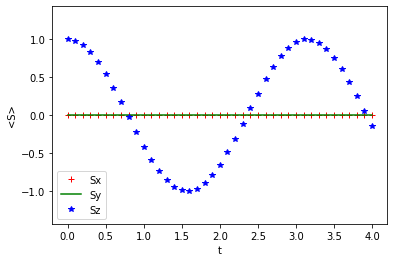

In [ ]:
# Plot the exact simulation results

fig, ax = plt.subplots()
ax.plot(t, s_result[:, 0],'r+', label='Sx')
ax.plot(t, s_result[:, 1],'g-', label='Sy')
ax.plot(t, s_result[:, 2],'b*', label='Sz')
ax.axis('equal')
plt.xlabel('t')
plt.ylabel('<S>')
leg = ax.legend();

Let's check if the expectation value of $<S>$ from the QSP simulation matches 
with the exact result. Indeed at t=1, they mathch very well with each other.



In [ ]:
print('<S_z> One-shot:\t %.6f' % s_result_qsp[2])
print('<S_z> Exact:\t %.6f' % s_result[20][2])
error_rel = abs((s_result_qsp[2] - s_result[20][2])/s_result[20][2])
print('Relative Error:\t %12.3e' % error_rel)

<S_z> One-shot:	 -0.653917
<S_z> Exact:	 -0.653644
Relative Error:	    4.185e-04



t      s_z (ED)      s_z (QSP)   Err \\
0.5 \\
1.0 \\
1.5 \\
2.0   -0.653644   -0.653917   4.185e-04 \\
2.5 \\
3.0 \\
3.5 \\
4.0 
